En este notebook está explicado todo el proceso para hacer la predicción de temperaturas, desde las funciones que se usan para preparar los datos hasta las predicciones finales.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
from math import sqrt
from numpy import split
from numpy import array
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from tensorflow import keras
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import RepeatVector
from keras.layers import TimeDistributed
from keras_tuner import RandomSearch
from keras_tuner import Hyperband
from keras_tuner import BayesianOptimization
from keras_tuner.engine.hyperparameters import HyperParameters
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, f_regression

In [2]:
import random
random.seed(123)

Casos a tratar:

- Sólo temperaturas
- prev + datos meteorologicos
- prev + hora/Season
- todas las variables
- Selección de características (cuántas¿?)

Además:
- Número de pasos previos (1,3,6)
- Número de pasos posteriores (6,12,18)(¿Hacer un grid?)

- Con escalado
- Sin escalado

Y modelos:
- LSTM
- RNN normal
- LSTM Bidireccional
- GRU

Sin diferenciar estados -> hacer predicción de todo (Ahora que ya funciona hace falta¿?)

Cargamos los datos con la información de todas las habitaciones con muestras cada 10 minutos

In [3]:
datos = pd.read_csv("data-room-10T-all.csv", sep = ";", index_col=0)

In [4]:
datos

,room,block,dif_cons,cons_total,V2,V12,V4,V26,V5_0,V5_1,...,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
Fecha,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:10:00+00:00,B1.1.010,A,0.23,1.55,20.0,21.0,0.0,0.0,1.0,0.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-01-01 00:10:00+00:00,B1.3.010,A,0.23,1.55,21.1,24.0,0.0,0.0,1.0,0.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-01-01 00:10:00+00:00,B1.1.008,A,0.23,1.55,19.9,21.0,0.0,0.0,1.0,0.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-01-01 00:10:00+00:00,B1.1.024,A,0.23,1.55,24.3,24.0,0.0,0.0,1.0,0.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
2021-01-01 00:10:00+00:00,B1.4.007,A,0.23,1.55,23.2,25.0,0.0,0.0,1.0,0.0,...,180.7,0.0,-2.3,0.0,0.0,1.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-17 23:50:00+00:00,B1.1.017,B,0.52,22403.96,22.7,24.5,0.0,0.0,1.0,0.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2021-12-17 23:50:00+00:00,B1.2.016,B,0.52,22403.96,22.3,25.0,0.0,0.0,1.0,0.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
2021-12-17 23:50:00+00:00,B1.0.026,C,0.09,41624.85,24.0,23.5,0.0,0.0,1.0,0.0,...,0.0,0.0,8.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


Función para identificar cuándo se da el patrón de encendido durante un cierto tiempo, y después un apagado durante otro tiempo dado. Como entrada recibe el DataFrame anterior, los edificios cuyas habitaciones nos interesen, el número de observaciones antes del apagado (ej. n_obs_antes = 3 son 3 muestras con los datos de los últimos 30 minutos), y el número de observaciones después del apagado (ej. n_obs_despues = 6 son los datos hasta 1 hora después del apagado). Y como salida devuelve un DataFrame en el que están agrupados esos conjuntos de observaciones cada vez que se reconoce el patrón indicado.

In [5]:
def find_events(data, edificios, n_obs_antes, n_obs_despues):
    #DataFrame vacío para la salida
    datos_all_rooms = pd.DataFrame()
    
    #Para que no haya problemas de slice y .loc
    pd.options.mode.chained_assignment = None
    
    #Cogemos los datos, y seleccionamos las habitaciones de cada edificio 
    datos = data
    edificio = edificios
    mask = datos['block'].isin(edificio)
    datos = datos.loc[mask]
    rooms = datos['room'].unique()
    
    #Iteramos sobre cada una de las habitaciones
    for room in rooms:
        mask = datos['room'].isin([room])
        datos_room = datos.loc[mask]
        datos_room = datos_room.drop(columns=['dif_cons','cons_total','block','room', 'V12','V26','V5_0','V5_1','V5_2'],axis=1)
        
        #Ponemos la columna de V4 como string y buscamos una secuencia de un 1 seguido de n 0's
        #El número de 0's lo establece n_obs_despues
        text = datos_room.V4.fillna(2).astype(int).astype(str).str.cat()
        time = n_obs_despues*10 #Esto nos da el tiempo en min. Ej: n_obs_despues = 6 -> time = 60'

        sequence = list(np.repeat(str(0),time/10))
        sequence.insert(0,'1'*n_obs_antes)
        sequence= ''.join(sequence)
        pattern = f'(?:{sequence})'
        findings = re.finditer(pattern, text)
        events = [(m.start(0)) for m in findings]  

        df = pd.DataFrame()
        #Para cada una de las secuencias de 1 y 0's, hacemos la selección de las instancias correspondientes
        #del conjunto de datos y las añadimos a un df, que iremos completando con cada uno de los eventos
        for i in range(len(events)):
            ref_inicio = events[i]+n_obs_antes #+1 porque la referencia de inicio es el primer 0 y events empieza en el 1
            df1 = datos_room.iloc[range(ref_inicio - n_obs_antes, ref_inicio + n_obs_despues),:]
            data = df1
            #Una vez que tenemos los eventos quitamos la columna de V4
            #data = data.drop(columns='V4')
            #n_vars = 1 if type(data) is list else data.shape[1]
            df = pd.concat([df,data])
        datos_all_rooms = pd.concat([datos_all_rooms, df])
    return datos_all_rooms

In [6]:
edificio = ['A']
n_obs_antes = 3
n_obs_despues = 6
datos_all_rooms = find_events(datos, edificio, n_obs_antes, n_obs_despues)

Vemos los estadísticos de los datos con los que vamos a trabajar

In [8]:
datos_all_rooms.describe()

,V2,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
count,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000,3456.000000
mean,27.871296,0.333333,24.600521,44.115828,462.131134,1.340828,159.695747,0.001939,10.290451,0.631655,0.356192,0.012153,0.098958,0.221354,0.440104,0.239583
std,2.568548,0.471473,7.643410,16.943733,302.900762,0.731137,105.403784,0.020394,5.858243,0.482425,0.478942,0.109584,0.298649,0.415218,0.496471,0.426891
min,15.800000,0.000000,5.400000,4.200000,0.000000,0.000000,0.000000,0.000000,-9.600000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,26.200000,0.000000,18.400000,32.100000,192.050000,0.800000,62.200000,0.000000,6.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,28.200000,0.000000,26.200000,41.800000,465.900000,1.300000,140.100000,0.000000,11.600000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,29.800000,1.000000,29.900000,54.000000,717.425000,1.800000,258.200000,0.000000,15.100000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000
max,35.600000,1.000000,44.000000,89.700000,1172.000000,3.600000,359.800000,0.500000,21.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


Selección de características (la función selecciona num_features y añade la variable a predecir a ese conjunto para hacer el slice del DataFrame).

In [20]:
def feature_selection(num_features, datos):
    data = datos
    select = SelectKBest(score_func=f_regression, k=num_features)
    z = select.fit_transform(data.iloc[:,1:], data.iloc[:,0]) 
    filter = select.get_support()
    features = np.array(data.iloc[:,1:].columns.values)
    features = features[filter].tolist()
    features.insert(0, 'V2')
    return features

In [21]:
features = feature_selection(10, datos_all_rooms)
datos_all_rooms = datos_all_rooms.loc[:,features]
print("Selected:", features)

Selected: ['V2', 'tmed', 'hrmed', 'radmed', 'vvmed', 'dvmed', 'dewpt', 'Hora_1', 'Season_1', 'Season_3', 'Season_4']


In [9]:
df = datos_all_rooms
print(df.shape)
df.head(2)

(3456, 16)


,V2,V4,tmed,hrmed,radmed,vvmed,dvmed,prec,dewpt,Hora_1,Hora_2,Hora_3,Season_1,Season_2,Season_3,Season_4
Fecha,,,,,,,,,,,,,,,,
2021-07-21 09:40:00+00:00,30.8,1.0,29.1,50.3,745.2,0.8,42.0,0.0,17.7,1.0,0.0,0.0,0.0,0.0,1.0,0.0
2021-07-21 09:50:00+00:00,30.9,1.0,29.9,47.3,768.7,0.9,2.2,0.0,17.5,1.0,0.0,0.0,0.0,0.0,1.0,0.0


Definimos una función para cambiar el orden del conjunto de muestras, de forma que al entrenar no aparezcan los ejemplos ordenados por fecha y edificio, con la intención de que así el algoritmo sea capaz de generalizar mejor.

In [61]:
#Hacemos el shuffle del df manualmente, de forma que cada grupo de <n_obs_antes+n_obs_despues> eventos siga junto,
#pero el orden de los grupos cambie para que así los conjuntos de train y test tengan ejemplos no consecutivos y 
#de cada uno de los edificios
def shuffle_df(datos, interval):
    arr_3D = df.values.reshape(-1,interval,df.shape[1])
    shuffle_idx = np.random.permutation(arr_3D.shape[0])
    arr_3D = arr_3D[shuffle_idx]
    shuffled_df = pd.DataFrame(arr_3D.reshape(df.shape[0],df.shape[1]))
    return shuffled_df

In [10]:
interval = n_obs_antes + n_obs_despues

In [11]:
df = shuffle_df(df, interval)

NameError: name 'shuffle_df' is not defined

In [ ]:
#df.to_csv('data-modelo-temp'+'.csv', sep=";", index= False)
#df = pd.read_csv('data-modelo-temp'+'.csv', sep=";")

Separamos el conjunto de datos en train y test, y hacemos el escalado de éstos (?).

In [12]:
#Sin escalado
#De momento funciona mejor así
def split_dataset(data, per_train, per_test, interval):
    # df.shape[0]/interval es el número de eventos que hay en total.
    # de eso nos quedamos con el 75% y para evitar inconsistencias usamos el ceil
    # después multiplicamos por interval porque cada evento tiene ese número de entradas
    train = data[0:int((interval*np.ceil(df.shape[0]/interval*per_train)))]
    test =  data[int((interval*np.ceil(df.shape[0]/interval*per_train))):int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test))))]
    val = data[int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test)))):]
    # Reestructuramos en grupos de <interval> muestras
    train = np.array(split(train, len(train)/(n_obs_antes+n_obs_despues)))
    test = np.array(split(test, len(test)/(n_obs_antes+n_obs_despues)))
    val = np.array(split(val, len(val)/(n_obs_antes+n_obs_despues)))
    return train, test, val

In [67]:
def split_dataset(data, per_train, per_test, interval):
    train = data[0:int((interval*np.ceil(df.shape[0]/interval*per_train)))]
    test =  data[int((interval*np.ceil(df.shape[0]/interval*per_train))):int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test))))]
    val = data[int((interval*np.ceil(df.shape[0]/interval*(per_train+per_test)))):]
    #Escalado en train y test por separado. Si no se hace aquí ya no se puede porque todo lo que sigue es con arrays 3D
    scaler_y = StandardScaler()
    train_y = scaler_y.fit_transform(train[:,0].reshape(-1, 1))
    val_y = scaler_y.fit_transform(val[:,0].reshape(-1, 1))
    test_y = scaler_y.transform(test[:,0].reshape(-1, 1))
    scaler_x = StandardScaler()
    train_x = scaler_x.fit_transform(train[:,1:]) 
    val_x = scaler_x.fit_transform(val[:,1:]) 
    test_x = scaler_x.transform(test[:,1:])
                                    #Guardar resultados con escalado
    
    #Rehacemos los DataFrames con los datos escalados para poder hacer el split
    train = pd.concat([pd.DataFrame(train_y),pd.DataFrame(train_x)], axis=1)
    test = pd.concat([pd.DataFrame(test_y),pd.DataFrame(test_x)], axis=1)
    val = pd.concat([pd.DataFrame(val_y),pd.DataFrame(val_x)], axis=1)

    train = np.array(split(train, len(train)/(n_obs_antes+n_obs_despues)))
    test = np.array(split(test, len(test)/(n_obs_antes+n_obs_despues)))
    val = np.array(split(val, len(val)/(n_obs_antes+n_obs_despues)))
    return train, test, val, scaler_x, scaler_y

In [13]:
# split en train, val y test
per_train = 0.7
per_test = 0.15
train, test, val = split_dataset(df.values, per_train, per_test, interval)
print('shape: [muestras, pasos de tiempo, características]')
print('train shape:', train.shape)
print('val shape:', val.shape)
print('test shape:', test.shape)

shape: [muestras, pasos de tiempo, características]
train shape: (269, 9, 16)
val shape: (57, 9, 16)
test shape: (58, 9, 16)


Preparamos los datos para aprendizaje supervisado

In [14]:
def to_supervised(train, n_input, n_out):
    # Ponemos los datos en 2D: una entrada para cada muestra y paso de tiempo con las n características
    data = train.reshape((train.shape[0]*train.shape[1], train.shape[2])) 
    X, y = list(), list()
    in_start = 0
    # Pasamos por todo el conjunto de datos, de step en step
    for _ in range(len(data)):
        # Definimos cuando empieza el input, cuando acaba, e igual para el output
        # En este caso el output empieza cuando acaba el input
        in_end = in_start + n_input
        out_end = in_end + n_out
        # Iteramos mientras haya ejemplos
        if out_end <= len(data):
            X.append(data[in_start:in_end, :]) # X son todas las variables en t
            y.append(data[in_end:out_end, 0])  # y es la temperatura en t+1 (si n_out=1)
        # Pasamos al siguiente instante de tiempo
        in_start += 1
    X = array(X)
    y = array(y)
    return X, y

In [15]:
n_input = n_obs_antes
n_out = 1

In [16]:
train_x, train_y = to_supervised(train, n_input, n_out)
test_x, test_y = to_supervised(test, n_input, n_out)
val_x, val_y = to_supervised(val, n_input, n_out)
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)   

train_x shape: (2418, 3, 16)
train_y shape: (2418, 1)
val_x shape: (510, 3, 16)
val_y shape: (510, 1)
test_x shape: (519, 3, 16)
test_y shape: (519, 1)


NO BORRAR LAS SIGUIENTES CELDAS HASTA ESTAR SEGUROS DE QUE ESTÁ BIEN

In [23]:
a = pd.concat([pd.DataFrame(test_y),pd.DataFrame(test_x.reshape(test_x.shape[0],test_x.shape[2]*n_obs_antes))], axis=1).iloc[0:40]

In [58]:
a = pd.concat([pd.DataFrame(train_y),pd.DataFrame(train_x.reshape(train_x.shape[0],train_x.shape[2]*n_obs_antes))], axis=1).iloc[0:40]

In [18]:
#Antes de corregir
#a.iloc[:,[0,1,12,23,2,13,24]]
a.iloc[:,[0,1,1+16,1+16*2,2,2+16,2+32]]
# Solo queremos predecir las 6 primeras filas de cada 9 (en el caso n_obs_antes=3, n_obs_despues=6)

,0,0,16,32,1,17,33
0,26.6,25.8,26.4,26.3,1.0,1.0,1.0
1,27.0,26.4,26.3,26.6,1.0,1.0,0.0
2,27.5,26.3,26.6,27.0,1.0,0.0,0.0
3,27.7,26.6,27.0,27.5,0.0,0.0,0.0
4,27.8,27.0,27.5,27.7,0.0,0.0,0.0
5,28.0,27.5,27.7,27.8,0.0,0.0,0.0
6,25.8,27.7,27.8,28.0,0.0,0.0,0.0
7,25.7,27.8,28.0,25.8,0.0,0.0,1.0
8,25.8,28.0,25.8,25.7,0.0,1.0,1.0
9,26.0,25.8,25.7,25.8,1.0,1.0,1.0


In [24]:
#Despues de corregir
a = a.iloc[:,[0,1,1+16,1+16*2,2,2+16,2+32]]
a.columns = ['T(t)', 'T(t-3)', 'T(t-2)', 'T(t-1)', 'V4(t-3)', 'V4(t-2)', 'V4(t-1)']
a
#Una vez que nos hemos quedado con los indices que interesan, esto es lo que vemos

,T(t),T(t-3),T(t-2),T(t-1),V4(t-3),V4(t-2),V4(t-1)
0,26.6,25.8,26.4,26.3,1.0,1.0,1.0
1,27.0,26.4,26.3,26.6,1.0,1.0,0.0
2,27.5,26.3,26.6,27.0,1.0,0.0,0.0
3,27.7,26.6,27.0,27.5,0.0,0.0,0.0
4,27.8,27.0,27.5,27.7,0.0,0.0,0.0
5,28.0,27.5,27.7,27.8,0.0,0.0,0.0
6,26.0,25.8,25.7,25.8,1.0,1.0,1.0
7,26.6,25.7,25.8,26.0,1.0,1.0,0.0
8,27.0,25.8,26.0,26.6,1.0,0.0,0.0
9,27.2,26.0,26.6,27.0,0.0,0.0,0.0


Como por la forma que tienen X e y hay observaciones que se crean que no tienen sentido, puesto que no trabajamos con una serie temporal, sino con varias, lo que hacemos es eliminar esas entradas que "mezclan" inputs y outputs de diferentes eventos. Para ello definimos unos índices que sean True o False y nos permitan hacer el slice. Así, si por ejemplo n_obs_despues = 6, n_obs_antes = 3 y n_input = 3, cada 9 filas nos quedamos con las 6 primeras, que son las que predicen las 6 observaciones de después, y las 3 restantes ya mezclan datos.

In [19]:
rows_to_keep = n_obs_despues 
rows_to_drop = n_obs_antes
period = rows_to_keep + rows_to_drop

In [20]:
train_sel = (np.arange(len(train_x)) % period) < rows_to_keep
test_sel = (np.arange(len(test_x)) % period) < rows_to_keep
val_sel = (np.arange(len(val_x)) % period) < rows_to_keep

In [21]:
train_x = train_x[train_sel,:,:]
train_y = train_y[train_sel,:] 

test_x = test_x[test_sel,:,:]
test_y = test_y[test_sel,:] 

val_x = val_x[val_sel,:,:]
val_y = val_y[val_sel,:] 

In [53]:
print('train_x shape:' , train_x.shape) 
print('train_y shape:'  , train_y.shape)     
print('test_x shape:' , test_x.shape)  
print('test_y shape:' , test_y.shape)   
print('val_x shape:' , val_x.shape)  
print('val_y shape:' , val_y.shape) 

train_x shape: (2634, 3, 16)
train_y shape: (2634, 1)
test_x shape: (564, 3, 16)
test_y shape: (564, 1)
val_x shape: (564, 3, 16)
val_y shape: (564, 1)


Definimos los parámetros que nos van a hacer falta para construir la red a partir de la forma de conjunto de train

In [76]:
n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
print('n_timesteps:' , n_timesteps) 
print('n_features:'  , n_features)     
print('n_outputs:' , n_outputs)    

n_timesteps: 6
n_features: 16
n_outputs: 1


El output va a ser siempre 1 porque vamos a hacer predicciones en cada paso de tiempo. La intención no es sacar una secuencia con un solo output del modelo dándole todos los datos de tiempos anteriores, para eso habría que reestructurar tanto la red como los reshapes que se hacen en distintos puntos del notebook.

In [77]:
# design network
model = Sequential()
model.add(LSTM(100, input_shape=(n_timesteps, n_features)))
model.add(RepeatVector(n_outputs))
model.add(LSTM(100, return_sequences=True))
model.add(TimeDistributed(Dense(50)))
model.add(TimeDistributed(Dense(1)))
model.compile(loss='mae', optimizer='adam')
history = model.fit(train_x, train_y, epochs=100, batch_size=64, validation_data=(val_x, val_y),
                    verbose=2, shuffle=False)

Epoch 1/100
71/71 - 5s - loss: 0.3588 - val_loss: 0.1865 - 5s/epoch - 65ms/step
Epoch 2/100
71/71 - 1s - loss: 0.1780 - val_loss: 0.1638 - 652ms/epoch - 9ms/step
Epoch 3/100
71/71 - 1s - loss: 0.1554 - val_loss: 0.1516 - 638ms/epoch - 9ms/step
Epoch 4/100
71/71 - 1s - loss: 0.1377 - val_loss: 0.1389 - 644ms/epoch - 9ms/step
Epoch 5/100
71/71 - 1s - loss: 0.1204 - val_loss: 0.1354 - 686ms/epoch - 10ms/step
Epoch 6/100
71/71 - 1s - loss: 0.1125 - val_loss: 0.1210 - 724ms/epoch - 10ms/step
Epoch 7/100
71/71 - 1s - loss: 0.1050 - val_loss: 0.1132 - 641ms/epoch - 9ms/step
Epoch 8/100
71/71 - 1s - loss: 0.1022 - val_loss: 0.1242 - 645ms/epoch - 9ms/step
Epoch 9/100
71/71 - 1s - loss: 0.0987 - val_loss: 0.1094 - 645ms/epoch - 9ms/step
Epoch 10/100
71/71 - 1s - loss: 0.0986 - val_loss: 0.1072 - 646ms/epoch - 9ms/step
Epoch 11/100
71/71 - 1s - loss: 0.0953 - val_loss: 0.0980 - 737ms/epoch - 10ms/step
Epoch 12/100
71/71 - 1s - loss: 0.0930 - val_loss: 0.0991 - 661ms/epoch - 9ms/step
Epoch 13/100

Epoch 100/100
71/71 - 1s - loss: 0.0641 - val_loss: 0.0894 - 935ms/epoch - 13ms/step


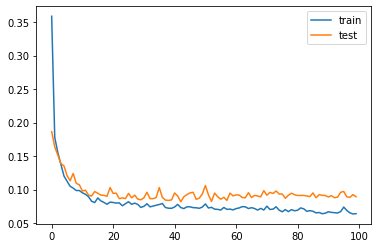

In [78]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

Preparamos el modelo para hacer ajuste de hiperparámetros y hacemos una búsqueda con BayesianOptimization

In [66]:
def build_model(hp):
    #Esta estructura hay que retocarla
    model = Sequential()
    #Numero de nodos en la primera capa 
    hp_units = hp.Choice('input_unit',[32,64,128])
    model.add(LSTM(units = hp_units, input_shape=(n_timesteps, n_features)))
    model.add(RepeatVector(n_outputs))   
    #Numero de capas ocultas
    for i in range(hp.Int('n_layers', 1, 2)):
        units_i = hp.Choice(f'dense_{i}_units',[32,64,128])
        model.add(LSTM(units = units_i, return_sequences=True))
    #Dropout
    hp_dropout = hp.Float('Dropout_rate',min_value=0,max_value=0.4,step=0.1)
    model.add(Dropout(hp_dropout))
    model.add(TimeDistributed(Dense(units = hp_units)))
    
    model.add(TimeDistributed(Dense(n_outputs)))
    
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
    
    model.compile(loss='mae', optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return model

In [67]:
tuner= BayesianOptimization(
        build_model,
        objective='val_loss',
        max_trials=15,
        num_initial_points=2,
        seed = 123,
        overwrite=True
        )

In [68]:
stop_early = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10)

In [69]:
#Si esto da un error que dice algo de Oracle, se arregla borrando los json que hay en /untitle_project
tuner.search(
        x=train_x,
        y=train_y,
        epochs=200,
        batch_size=128,
        validation_data=(val_x,val_y),
        verbose=2,
        shuffle=False,
        callbacks=[stop_early]
)

Trial 15 Complete [00h 01m 16s]
val_loss: 0.09074652194976807

Best val_loss So Far: 0.08688264340162277
Total elapsed time: 00h 20m 37s
INFO:tensorflow:Oracle triggered exit


In [73]:
model = tuner.get_best_models(num_models=1)[0]

Vemos la arquitectura del modelo que mejor funciona

In [75]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100)               46800     
                                                                 
 repeat_vector_1 (RepeatVect  (None, 1, 100)           0         
 or)                                                             
                                                                 
 lstm_4 (LSTM)               (None, 1, 100)            80400     
                                                                 
 time_distributed_2 (TimeDis  (None, 1, 50)            5050      
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 1, 1)             51        
 tributed)                                                       
                                                      

Hacemos las predicciones sobre el conjunto de test

In [4]:
#No borrar esto aún
n_predict = 6
n_obs_despues = 6
n = n_obs_despues - n_predict 
m = n_predict   #Salto de n cada m
test_index = [j for i in range(0,618, n+m) for j in range(i, m+i) if j<618]
#len(test_index) debe ser igual a test.shape[0]*n_predict, si no, algo está mal
#len(test_index)==test.shape[0]*n_predict

In [6]:
 for i in test_index:
    if (i < 618) & (i not in range(n_predict-1,618, n_obs_despues)):
         print(i)

0
1
2
3
4
6
7
8
9
10
12
13
14
15
16
18
19
20
21
22
24
25
26
27
28
30
31
32
33
34
36
37
38
39
40
42
43
44
45
46
48
49
50
51
52
54
55
56
57
58
60
61
62
63
64
66
67
68
69
70
72
73
74
75
76
78
79
80
81
82
84
85
86
87
88
90
91
92
93
94
96
97
98
99
100
102
103
104
105
106
108
109
110
111
112
114
115
116
117
118
120
121
122
123
124
126
127
128
129
130
132
133
134
135
136
138
139
140
141
142
144
145
146
147
148
150
151
152
153
154
156
157
158
159
160
162
163
164
165
166
168
169
170
171
172
174
175
176
177
178
180
181
182
183
184
186
187
188
189
190
192
193
194
195
196
198
199
200
201
202
204
205
206
207
208
210
211
212
213
214
216
217
218
219
220
222
223
224
225
226
228
229
230
231
232
234
235
236
237
238
240
241
242
243
244
246
247
248
249
250
252
253
254
255
256
258
259
260
261
262
264
265
266
267
268
270
271
272
273
274
276
277
278
279
280
282
283
284
285
286
288
289
290
291
292
294
295
296
297
298
300
301
302
303
304
306
307
308
309
310
312
313
314
315
316
318
319
320
321
322
324
325
326
3

In [79]:
def predict(datos_test_x, datos_test_y, n_pred, n_obs_despues, modelo):
    test_y = datos_test_y
    #Creamos una lista vacía para las predicciones
    predictions = list()
    #Ponemos los índices i y j a 0
    i=0
    j=0
    #Indice para hacer predicciones en un horizonte de tiempo concreto
    #Saltamos n filas cada m. Ej: tenemos n_obs_despues=12 pero queremos predecir solo la hora siguiente así
    #que predecimos 6 filas, saltamos otras 6 (que serían la 2a hora) y repetimos
    n = n_obs_despues - n_predict 
    m = n_predict   #Salto de n cada m
    test_index = [j for i in range(0,len(test_x), n+m) for j in range(i, m+i) if j<len(test_x)]
    for i in test_index:
        data = test_x[i,:,:]
        # Cogemos como input los valores del instante de tiempo anterior al que vamos a predecir
        # Recordar que el x lleva un lag de 1 respecto a la y, por eso es el elemento i y no el i-1
        # Le damos la forma que el modelo necesita para predecir
        input_x = data.reshape((1, n_timesteps, n_features))
        
        # Prediccion para cada paso de tiempo
        yhat = model.predict(input_x, verbose=0)
        yhat_sequence = yhat[0] 

        # Guardamos las predicciones
        predictions.append(yhat_sequence)
        
        # Reescribimos el valor de la temperatura del siguiente paso con la prediccion
        # Añadimos una condición más para que en el último paso de cada evento no actualice, ya
        # que reescribiría datos de otro caso
        if i < len(test_x) and (j not in range(n_predict-1,len(test_x), n_obs_despues)):
            try: test_x[i+1,n_input,0] = yhat[0]
            except IndexError: continue
            #La excepción es porque al llegar al final no hay un i+1 que actualizar y salta un IndexError
        else: break
        j+=1
        
    predictions = array(predictions)
    #Seleccionamos solo los ejemplos del conjunto de test que vamos a predecir
    test_y = test_y[test_index,:]
    return predictions, test_y

In [80]:
n_predict = 6 #Timesteps a predecir
prediction, test_y = predict(test_x, test_y, n_predict, n_obs_despues, model)

In [53]:
prediction.shape

(564, 1, 1)

In [81]:
pred_shape_0 = test.shape[0]
pred_shape_1 = n_predict 
# Ponemos la prediccion y el conjunto de test en 2D: muestras*timesteps
prediction = prediction.reshape(pred_shape_0, pred_shape_1)
test_y = test_y.reshape(pred_shape_0, pred_shape_1)

print('prediction shape:', prediction.shape)
print('test_y shape:', test_y.shape)

prediction shape: (81, 6)
test_y shape: (81, 6)


In [82]:
prediction = scaler_y.inverse_transform(prediction)
test_y = scaler_y.inverse_transform(test_y)

Calculamos las métricas:

In [83]:
#CON ESCALADO 6/12
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.347
Test CVRMSE: 1.233
Test R squared: 0.976


In [33]:
#SIN ESCALADO 6/12
rmse = np.sqrt(mean_squared_error(test_y,prediction))
cvrmse = rmse/np.mean(test_y)*100
r2 = r2_score(test_y, prediction)
print('Test RMSE: %.3f' % rmse)
print('Test CVRMSE: %.3f' % cvrmse)
print('Test R squared: %.3f' % r2)

Test RMSE: 0.526
Test CVRMSE: 1.860
Test R squared: 0.951


In [ ]:
#model.save('model_temp_LSTM_in1_out1_.h5')
#model = keras.models.load_model('model_temp.h5')

In [485]:
#Ejemplo para nombrar los modelos
#'model_temp_tecnica_numeracion_prevX_postY_predstepsZ'
#'model_temp_lstm_01_prev1_post6_predsteps6'

Representamos los datos reales frente a las predicciones

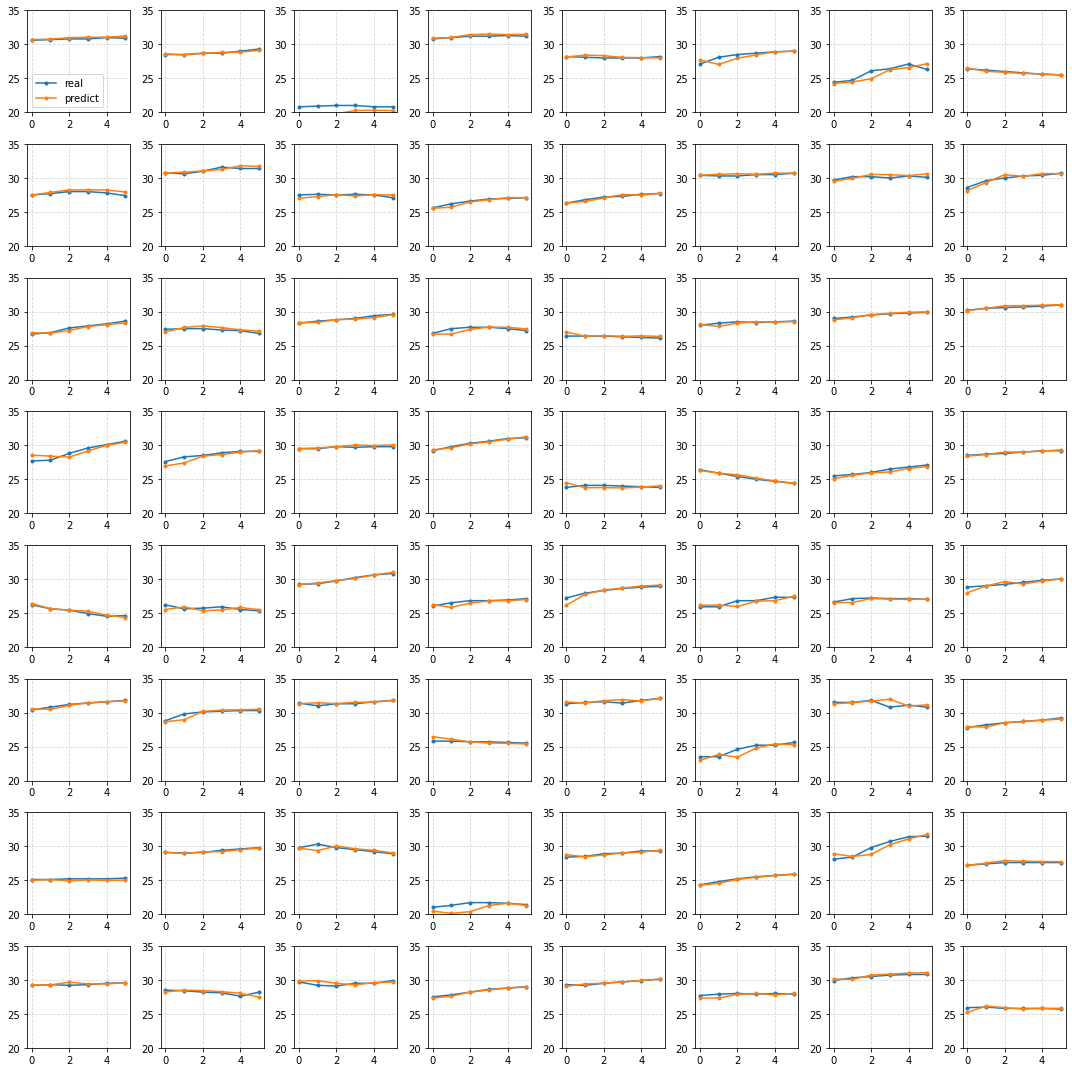

In [84]:
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k+i,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

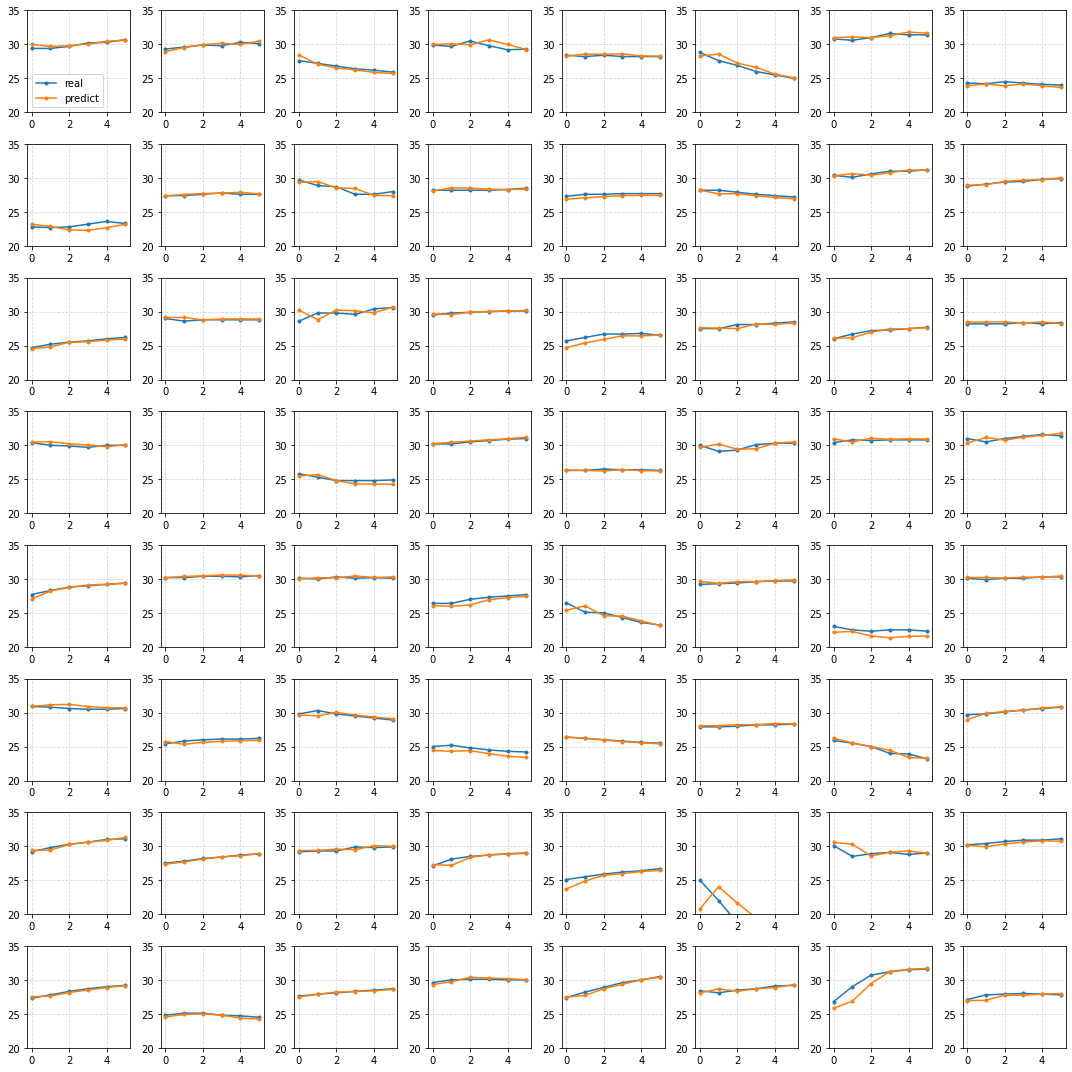

In [95]:
fig, axs = plt.subplots(figsize=(15,15), nrows = 8, ncols =8)
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        #print([i,j,k])
        axs[i,j].plot(test_y[k+i+64,:], label = 'real', marker='.')
        axs[i,j].plot(prediction[k++i+64,:], label = 'predict', marker='.')
        axs[i,j].set_ylim(20,35)
        axs[i,j].grid(linestyle = "--", alpha=0.5)
        axs[0,0].legend()
    fig.tight_layout()
plt.show()

In [440]:
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        print([i,j,k+i])

[0, 0, 0]
[0, 1, 1]
[0, 2, 2]
[0, 3, 3]
[0, 4, 4]
[0, 5, 5]
[0, 6, 6]
[0, 7, 7]
[1, 0, 8]
[1, 1, 9]
[1, 2, 10]
[1, 3, 11]
[1, 4, 12]
[1, 5, 13]
[1, 6, 14]
[1, 7, 15]
[2, 0, 16]
[2, 1, 17]
[2, 2, 18]
[2, 3, 19]
[2, 4, 20]
[2, 5, 21]
[2, 6, 22]
[2, 7, 23]
[3, 0, 24]
[3, 1, 25]
[3, 2, 26]
[3, 3, 27]
[3, 4, 28]
[3, 5, 29]
[3, 6, 30]
[3, 7, 31]
[4, 0, 32]
[4, 1, 33]
[4, 2, 34]
[4, 3, 35]
[4, 4, 36]
[4, 5, 37]
[4, 6, 38]
[4, 7, 39]
[5, 0, 40]
[5, 1, 41]
[5, 2, 42]
[5, 3, 43]
[5, 4, 44]
[5, 5, 45]
[5, 6, 46]
[5, 7, 47]
[6, 0, 48]
[6, 1, 49]
[6, 2, 50]
[6, 3, 51]
[6, 4, 52]
[6, 5, 53]
[6, 6, 54]
[6, 7, 55]
[7, 0, 56]
[7, 1, 57]
[7, 2, 58]
[7, 3, 59]
[7, 4, 60]
[7, 5, 61]
[7, 6, 62]
[7, 7, 63]


In [444]:
i=0
j=0
k=0
for i in range(0,8):
    for j, k in enumerate(range(k,k+8)):
        print([i,j,k+i+63])

[0, 0, 63]
[0, 1, 64]
[0, 2, 65]
[0, 3, 66]
[0, 4, 67]
[0, 5, 68]
[0, 6, 69]
[0, 7, 70]
[1, 0, 71]
[1, 1, 72]
[1, 2, 73]
[1, 3, 74]
[1, 4, 75]
[1, 5, 76]
[1, 6, 77]
[1, 7, 78]
[2, 0, 79]
[2, 1, 80]
[2, 2, 81]
[2, 3, 82]
[2, 4, 83]
[2, 5, 84]
[2, 6, 85]
[2, 7, 86]
[3, 0, 87]
[3, 1, 88]
[3, 2, 89]
[3, 3, 90]
[3, 4, 91]
[3, 5, 92]
[3, 6, 93]
[3, 7, 94]
[4, 0, 95]
[4, 1, 96]
[4, 2, 97]
[4, 3, 98]
[4, 4, 99]
[4, 5, 100]
[4, 6, 101]
[4, 7, 102]
[5, 0, 103]
[5, 1, 104]
[5, 2, 105]
[5, 3, 106]
[5, 4, 107]
[5, 5, 108]
[5, 6, 109]
[5, 7, 110]
[6, 0, 111]
[6, 1, 112]
[6, 2, 113]
[6, 3, 114]
[6, 4, 115]
[6, 5, 116]
[6, 6, 117]
[6, 7, 118]
[7, 0, 119]
[7, 1, 120]
[7, 2, 121]
[7, 3, 122]
[7, 4, 123]
[7, 5, 124]
[7, 6, 125]
[7, 7, 126]


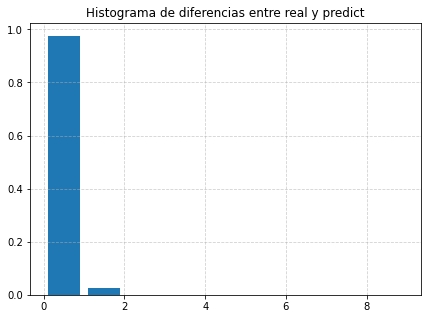

In [85]:
differences = np.abs((prediction - test_y).mean(axis=1)).round(0).astype(int)
differences

fig = plt.figure(figsize =(7, 5))
plt.grid(linestyle = "--", alpha=0.6)
plt.hist(differences, bins= [0,1,2,3,4,5,6,7,8,9], density=True, rwidth=0.8, align='mid')
#plt.xticks(np.arange(0, 10, 1))
plt.title("Histograma de diferencias entre real y predict")
plt.show()